In [53]:
import random
random.seed(42)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, LabelBinarizer, StandardScaler, OneHotEncoder

from sklearn.metrics import roc_auc_score, accuracy_score, silhouette_score, RocCurveDisplay, classification_report

from sklearn import metrics, svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('musicData.csv')

# data imputation
data.replace("?", np.nan, inplace=True)
data.fillna(data.mode().iloc[0], inplace=True)
data.dropna(inplace=True)
data = data.drop(['obtained_date', 'instance_id', 'artist_name', 'track_name'], axis=1)

# data encoding
data['mode'] = data['mode'].replace({'Major': 0, 'Minor': 1})
data = pd.get_dummies(data, columns=['key'])
data = data.drop(data.columns[-1], axis=1) # avoid dummy variable trap

genres = data['music_genre'].unique()

X_train = pd.DataFrame()
y_train = pd.Series()
X_test = pd.DataFrame()
y_test = pd.Series()
X_val = pd.DataFrame()
y_val = pd.Series()

for genre in genres:
    genre_data = data[data['music_genre'] == genre]
    genre_sample = genre_data.sample(n=500)
    genre_train = genre_data.drop(genre_sample.index)
    genre_val = genre_train.sample(frac=0.1)
    genre_train = genre_train.drop(genre_val.index)

    X_train = pd.concat([X_train, genre_train.drop(['music_genre'], axis=1)])
    y_train = pd.concat([y_train, genre_train['music_genre']])

    X_val = pd.concat([X_val, genre_val.drop(['music_genre'], axis=1)])
    y_val = pd.concat([y_val, genre_val['music_genre']])

    X_test = pd.concat([X_test, genre_sample.drop(['music_genre'], axis=1)])
    y_test = pd.concat([y_test, genre_sample['music_genre']])

# Standardize non-categorical features
scaler = StandardScaler()
num_cols = data.columns[:8].append(data.columns[9:12])
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])

le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
X = pd.concat([X_train, X_test], axis = 0)
y = pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_test)], axis = 0)
y_train = le.inverse_transform(y_train)
y_test = le.inverse_transform(y_test)
y_org = pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_test)], axis = 0)


In [75]:
def opt_silhouette_score(X_cluster):
    silhouette_scores = []
    for n in range(5,15):
        kmeans = KMeans(n_clusters=n, n_init='auto')
        cluster_labels = kmeans.fit_predict(X_cluster)
        silhouette_scores.append(silhouette_score(X_cluster, cluster_labels))
    print(silhouette_scores)
    optimal_num_clusters = np.argmax(silhouette_scores) + 10
    # print(f"Optimal number of clusters: {optimal_num_clusters}")
    return optimal_num_clusters

def plot_kmeans(X_cluster, optimal_num_clusters):
    kmeans = KMeans(n_clusters=optimal_num_clusters, n_init='auto')
    cluster_labels = kmeans.fit_predict(X_cluster)
    print(f"Sum of squared distances of samples to their closest cluster center:", kmeans.inertia_)
    plot = plt.scatter(X_cluster[:,0], X_cluster[:,1], c=cluster_labels)
    plt.xlabel("Dimenson 1")
    plt.ylabel("Dimenson 2")
    _ = plt.title(f"KMeans with {optimal_num_clusters} clusters")
    plt.show()

def cluster(model):
    X_cluster = model.fit_transform(X, y)
    plot = plt.scatter(X_cluster[:,0], X_cluster[:,1], c=y)
    handles, labels = plot.legend_elements()
    lg = plt.legend(handles, list(np.unique(y_org)), loc = 'center right', bbox_to_anchor=(1.4, 0.5))
    plt.xlabel("Dimenson 1")
    plt.ylabel("Dimenson 2")
    _ = plt.title(f"{model.__class__.__name__}")
    plt.show()
    return X_cluster


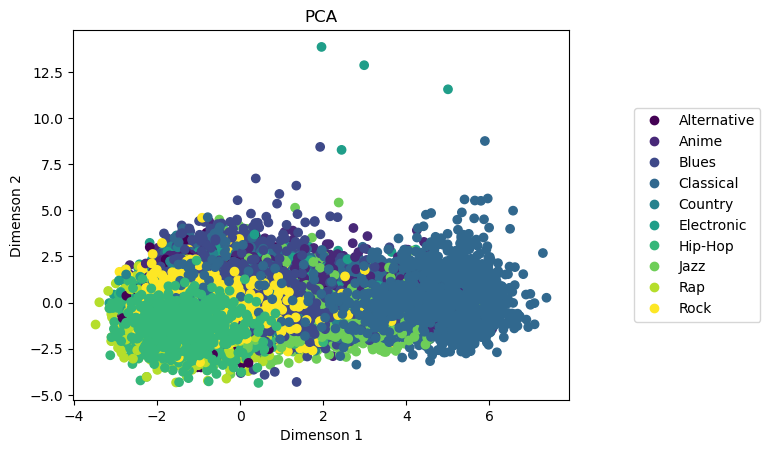

[0.3538357788990944, 0.33903550514287806, 0.32878240218562804, 0.3293062772631847, 0.3282765899197977, 0.321094309387817, 0.3233383033826814, 0.3186528703160772, 0.3215744234947138, 0.3201634026784417]
Sum of squared distances of samples to their closest cluster center: 25209.761644117327


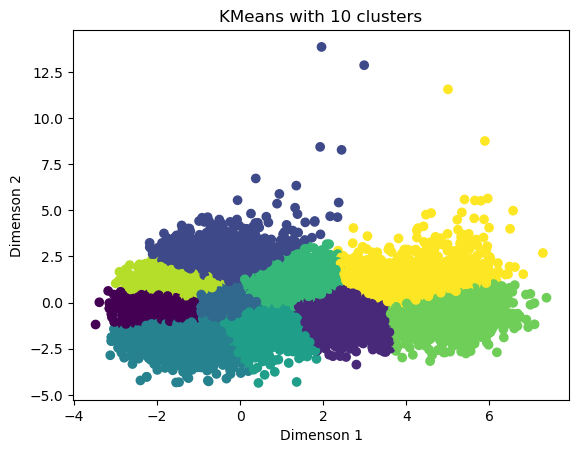

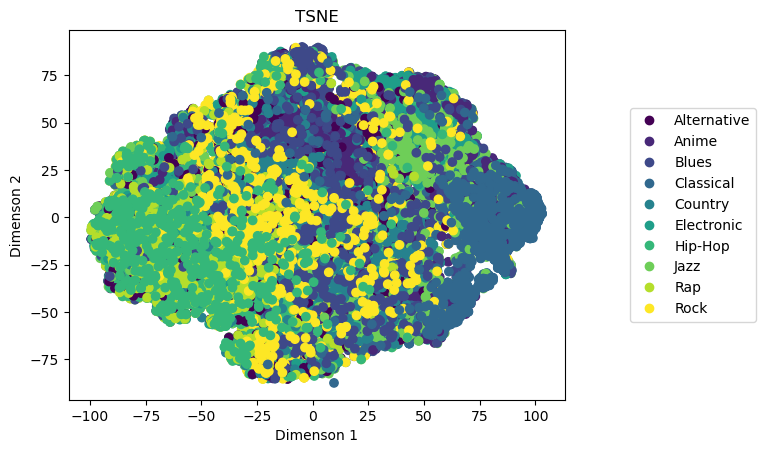

[0.36760357, 0.3791991, 0.39714214, 0.38412747, 0.37906623, 0.37850752, 0.3820896, 0.3634522, 0.38064566, 0.38266218]
Sum of squared distances of samples to their closest cluster center: 14702131.0


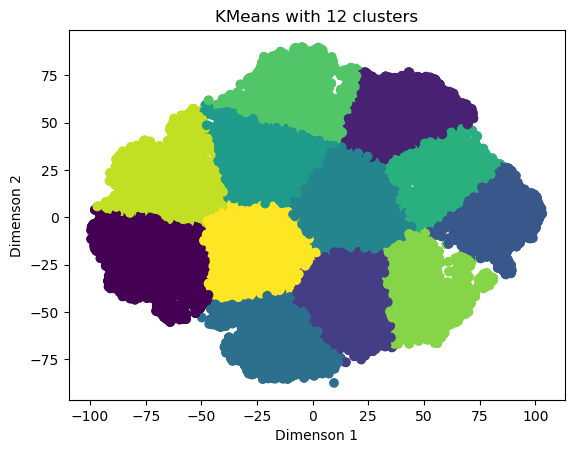

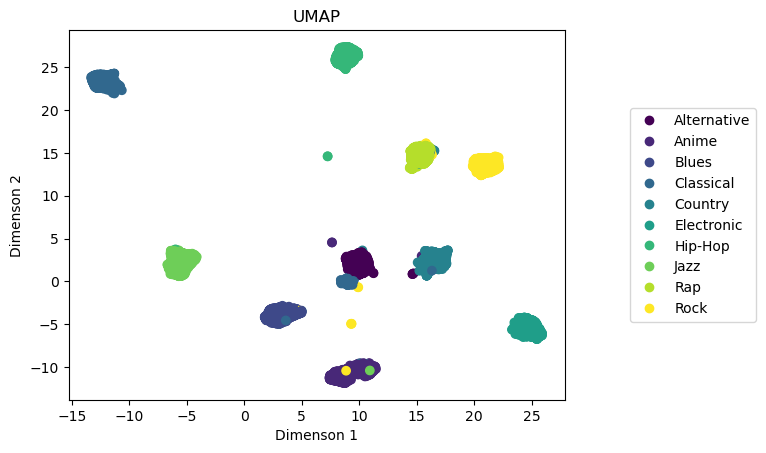

[0.5773546, 0.65722317, 0.75499576, 0.8097194, 0.8526947, 0.87618756, 0.86098564, 0.8104027, 0.77224386, 0.742624]
Sum of squared distances of samples to their closest cluster center: 21285.044921875


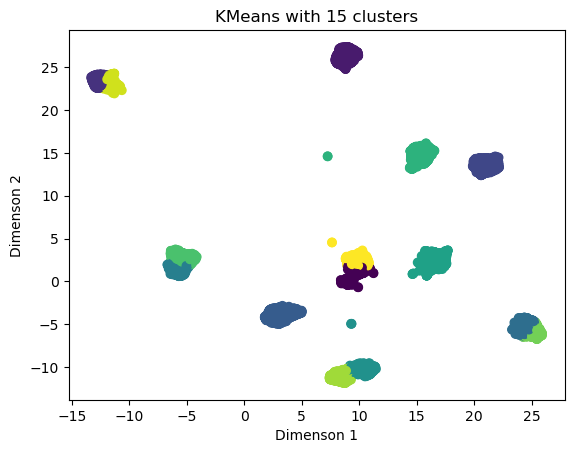

In [10]:
pca_model = cluster(PCA(n_components=2))
pca_opt_clus = opt_silhouette_score(pca_model)
plot_kmeans(pca_model, pca_opt_clus)

tsne_model = cluster(TSNE(n_components=2, perplexity=50))
tsne_opt_clus = opt_silhouette_score(tsne_model)
plot_kmeans(tsne_model, tsne_opt_clus)

umap_model = cluster(umap.UMAP(n_components=2, n_neighbors=200, min_dist=0.1))
umap_opt_clus = opt_silhouette_score(umap_model)
plot_kmeans(umap_model, umap_opt_clus)


In [1]:
# tune hyperparameters for UMAP
# neighbors = [5, 10, 20, 50, 100, 200]
# dist = [0.1, 0.25, 0.5, 0.8, 0.99]
# for n in neighbors:
#     for d in dist:
#         umap_model = umap.UMAP(n_components=2, n_neighbors=n, min_dist=d)
#         print(f"n_neighbors: {n}, min_dist: {d}")
#         cluster(umap_model)

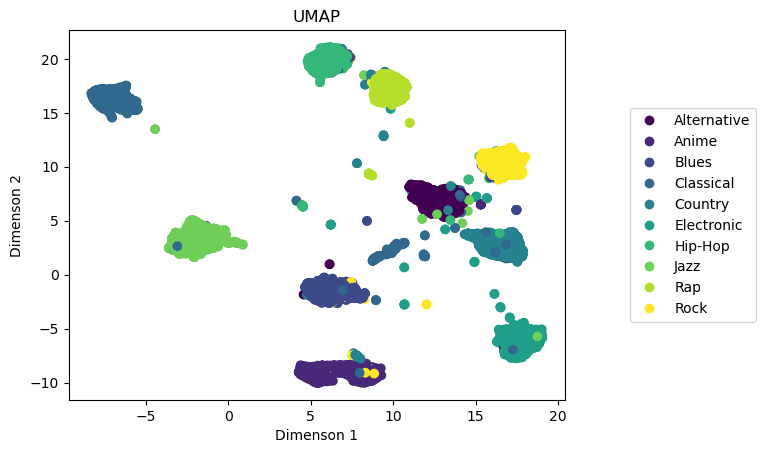

Sum of squared distances of samples to their closest cluster center: 55391.19921875


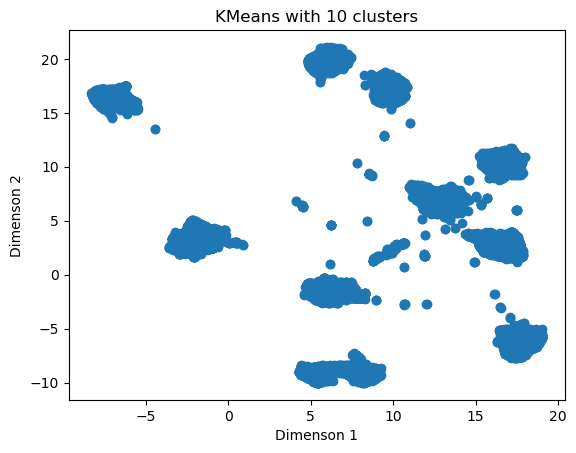

In [76]:
umap_model = cluster(umap.UMAP(n_components=2, n_neighbors=50, min_dist=0.1))
umap_opt_clus = opt_silhouette_score(umap_model)
print(f"Optimal number of clusters: {umap_opt_clus}")
plot_kmeans(umap_model, 10)

In [64]:

xgb_model = xgb.XGBClassifier(device='cuda')
xgb_search = {
    "n_estimators": [100, 200, 400],
    "max_depth": [3, 6, 9],
    "gamma" : [0.01, 0.1],
    "learning_rate": [0.001, 0.01, 0.1, .3, 1]
}
log_model = LogisticRegression()
log_search = {
    "C": [.01, .05, 0.1, 1, 10]
}
ada_model = AdaBoostClassifier()
ada_search = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.001, 0.01, 0.1, 1]
}
svm_model = svm.SVC()
svm_search = {
    "C": [0.1, 1, 10],
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid']
}

In [21]:
# tune hyperparameters for XGBoost
le = LabelEncoder()
y_val_temp = le.fit_transform(y_val)
xgb_params = {
    "n_estimators": 0,
    "max_depth": 0,
    "gamma" : 0,
    "learning_rate": 0,
}
prev_accuracy = 0
for n in xgb_search["n_estimators"]:
    for d in xgb_search["max_depth"]:
        for g in xgb_search["gamma"]:
            for l in xgb_search["learning_rate"]:
                xgb_model = xgb.XGBClassifier(n_estimators=n, 
                                              max_depth=d, 
                                              gamma=g, 
                                              learning_rate=l, 
                                              device='cuda')

                xgb_model.fit(X_val, y_val_temp, eval_set=[(X_test, y_test)], verbose=False)
                y_pred = xgb_model.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)
                if accuracy > prev_accuracy:
                    prev_accuracy = accuracy
                    xgb_params["n_estimators"] = n
                    xgb_params["max_depth"] = d
                    xgb_params["gamma"] = g
                    xgb_params["learning_rate"] = l
                    print(f"{n} {d} {g} {l} Accuracy: {accuracy}")
print("optimal xgb parameters:", xgb_params)

100 3 0.01 0.001 Accuracy: 0.481
100 3 0.01 0.01 Accuracy: 0.5012
100 3 0.01 0.1 Accuracy: 0.5624
100 3 0.1 0.1 Accuracy: 0.563
optimal xgb parameters: {'n_estimators': 100, 'max_depth': 3, 'gamma': 0.1, 'learning_rate': 0.1}


In [65]:
log_params = {
    "C": 0
}
prev_accuracy = 0
for c in log_search["C"]:
    log_model = LogisticRegression(C=c)
    log_model.fit(X_val, y_val)
    y_pred = log_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    if accuracy > prev_accuracy:
        prev_accuracy = accuracy
        log_params["C"] = c
        print(f"{c} Accuracy: {accuracy}")
print("optimal log parameters:", log_params)

0.01 Accuracy: 0.5006
0.05 Accuracy: 0.5084
0.1 Accuracy: 0.5102
optimal log parameters: {'C': 0.1}


In [67]:
ada_params = { 
    "n_estimators": 0,
    "learning_rate": 0
}
prev_accuracy = 0
for n in ada_search["n_estimators"]:
    for l in ada_search["learning_rate"]:
        ada_model = AdaBoostClassifier(n_estimators=n, learning_rate=l)
        ada_model.fit(X_val, y_val)
        y_pred = ada_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        if accuracy > prev_accuracy:
            prev_accuracy = accuracy
            ada_params["n_estimators"] = n
            ada_params["learning_rate"] = l
            print(f"{n} {l} Accuracy: {accuracy}")
print("optimal ada parameters:", ada_params)

50 0.001 Accuracy: 0.1962
50 0.01 Accuracy: 0.2752
50 0.1 Accuracy: 0.4384
100 0.1 Accuracy: 0.4646
200 0.1 Accuracy: 0.4826
optimal ada parameters: {'n_estimators': 200, 'learning_rate': 0.1}


In [68]:
svm_params = {
    "C": 0,
    "kernel": ""
}
prev_accuracy = 0
for c in svm_search["C"]:
    for k in svm_search["kernel"]:
        svm_model = svm.SVC(C=c, kernel=k)
        svm_model.fit(X_val, y_val)
        y_pred = svm_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        if accuracy > prev_accuracy:
            prev_accuracy = accuracy
            svm_params["C"] = c
            svm_params["kernel"] = k
            print(f"{c} {k} Accuracy: {accuracy}")
print("optimal svm parameters:", svm_params)

0.1 linear Accuracy: 0.5202
1 linear Accuracy: 0.5206
1 rbf Accuracy: 0.5374
optimal svm parameters: {'C': 1, 'kernel': 'rbf'}


              precision    recall  f1-score   support

 Alternative       0.41      0.35      0.38       500
       Anime       0.63      0.60      0.61       500
       Blues       0.49      0.51      0.50       500
   Classical       0.77      0.80      0.79       500
     Country       0.44      0.57      0.50       500
  Electronic       0.56      0.53      0.55       500
     Hip-Hop       0.43      0.47      0.45       500
        Jazz       0.52      0.42      0.46       500
         Rap       0.45      0.36      0.40       500
        Rock       0.53      0.63      0.58       500

    accuracy                           0.52      5000
   macro avg       0.52      0.52      0.52      5000
weighted avg       0.52      0.52      0.52      5000

Macro-averaged OvR AUROC: 0.90
Macro-averaged OvO AUROC: 0.90


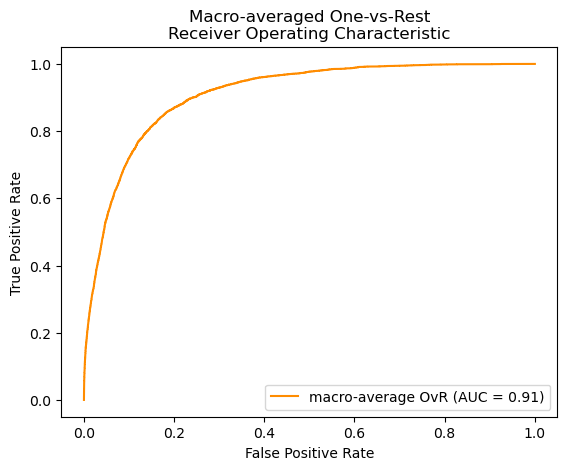

In [66]:
log_model = LogisticRegression(C=.1)
y_score = log_model.fit(X_train, y_train).predict_proba(X_test)

lb = LabelBinarizer().fit(y_train)
y_onehot_test = lb.transform(y_test)

display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="macro-average OvR",
    color="darkorange",   
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Macro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)
macro_roc_auc_ovo = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovo",
    average="macro",
)
macro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="macro",
)

print(classification_report(y_test, log_model.predict(X_test)))
print(f"Macro-averaged OvR AUROC: {macro_roc_auc_ovr:.2f}")
print(f"Macro-averaged OvO AUROC: {macro_roc_auc_ovo:.2f}")

              precision    recall  f1-score   support

 Alternative       0.40      0.36      0.38       500
       Anime       0.69      0.59      0.64       500
       Blues       0.50      0.50      0.50       500
   Classical       0.76      0.77      0.76       500
     Country       0.57      0.50      0.53       500
  Electronic       0.55      0.48      0.51       500
     Hip-Hop       0.44      0.57      0.49       500
        Jazz       0.40      0.42      0.41       500
         Rap       0.45      0.30      0.36       500
        Rock       0.50      0.74      0.60       500

    accuracy                           0.52      5000
   macro avg       0.53      0.52      0.52      5000
weighted avg       0.53      0.52      0.52      5000

Macro-averaged OvR AUROC: 0.88
Macro-averaged OvO AUROC: 0.88


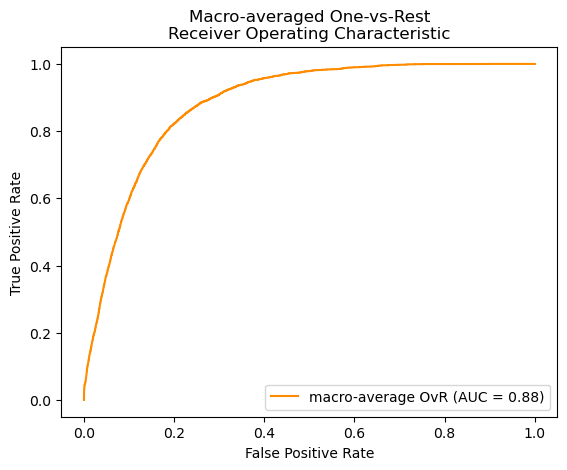

In [69]:
ada_model = AdaBoostClassifier(n_estimators=200, learning_rate=0.1)
y_score = ada_model.fit(X_train, y_train).predict_proba(X_test)

lb = LabelBinarizer().fit(y_train)
y_onehot_test = lb.transform(y_test)

display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="macro-average OvR",
    color="darkorange",   
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Macro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)
macro_roc_auc_ovo = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovo",
    average="macro",
)
macro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="macro",
)

print(classification_report(y_test, ada_model.predict(X_test)))
print(f"Macro-averaged OvR AUROC: {macro_roc_auc_ovr:.2f}")
print(f"Macro-averaged OvO AUROC: {macro_roc_auc_ovo:.2f}")


              precision    recall  f1-score   support

           0       0.44      0.37      0.40       500
           1       0.74      0.70      0.72       500
           2       0.57      0.54      0.56       500
           3       0.83      0.84      0.84       500
           4       0.51      0.55      0.53       500
           5       0.64      0.54      0.59       500
           6       0.43      0.52      0.47       500
           7       0.55      0.51      0.53       500
           8       0.47      0.37      0.41       500
           9       0.53      0.73      0.61       500

    accuracy                           0.57      5000
   macro avg       0.57      0.57      0.57      5000
weighted avg       0.57      0.57      0.57      5000

Macro-averaged OvR AUROC: 0.92
Macro-averaged OvO ROC AUC score:
0.92


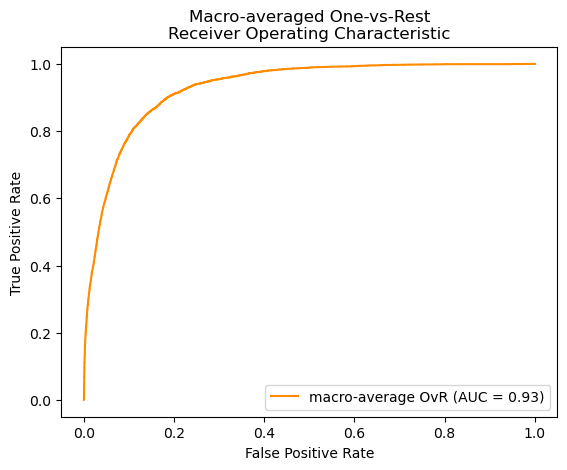

In [77]:
svm_model = svm.SVC(kernel='rbf', probability=True)
y_score = svm_model.fit(X_train, y_train).predict_proba(X_test)

lb = LabelBinarizer().fit(y_train)
y_onehot_test = lb.transform(y_test)

display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="macro-average OvR",
    color="darkorange",   
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Macro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)
macro_roc_auc_ovo = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovo",
    average="macro",
)
macro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="macro",
)

print(classification_report(y_test, svm_model.predict(X_test)))
print(f"Macro-averaged OvR AUROC: {macro_roc_auc_ovr:.2f}")
print(f"Macro-averaged OvO ROC AUC score:\n{macro_roc_auc_ovo:.2f}")


Accuracy: 0.57
              precision    recall  f1-score   support

           0       0.49      0.39      0.43       500
           1       0.80      0.75      0.77       500
           2       0.57      0.51      0.54       500
           3       0.85      0.83      0.84       500
           4       0.57      0.62      0.59       500
           5       0.63      0.54      0.58       500
           6       0.43      0.46      0.45       500
           7       0.52      0.48      0.50       500
           8       0.43      0.41      0.42       500
           9       0.50      0.74      0.60       500

    accuracy                           0.57      5000
   macro avg       0.58      0.57      0.57      5000
weighted avg       0.58      0.57      0.57      5000

Macro-averaged One-vs-Rest ROC AUC score:
0.93
Macro-averaged OvO ROC AUC score:
0.93


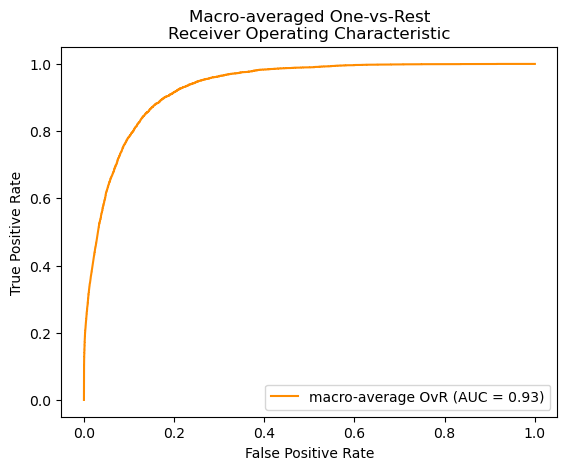

In [71]:
xgb_model = xgb.XGBClassifier(n_estimators=100, 
                              max_depth= 3, 
                              gamma= 0.1, 
                              learning_rate= 0.1,
                              device='cuda')

le = LabelEncoder()
y_train = le.fit_transform(y_train)

y_test = le.transform(y_test)

xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
y_score = xgb_model.predict_proba(X_test)

y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(metrics.classification_report(y_test, xgb_model.predict(X_test)))

lb = LabelBinarizer().fit(y_train)
y_onehot_test = lb.transform(y_test)

macro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="macro",
)
macro_roc_auc_ovo = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovo",
    average="macro",
)
display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="macro-average OvR",
    color="darkorange",   
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Macro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)
print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")
print(f"Macro-averaged OvO ROC AUC score:\n{macro_roc_auc_ovo:.2f}")
